# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias_rows = azdias.shape[0]
azdias_columns = azdias.shape[1]
feat_info_rows = feat_info.shape[0]
feat_info_columns = feat_info.shape[1]
print('The number of rows in the general demographics AZDIAS data: {}'.format(azdias_rows))
print('The number of columns in the general demographics AZDIAS data: {}'.format(azdias_columns))
print('The number of rows in the feature summary file: {}'.format(feat_info_rows))
print('The number of columns in the feature summary file: {}'.format(feat_info_columns))
display(azdias.head(10))
display(feat_info.head(10))

The number of rows in the general demographics AZDIAS data: 891221
The number of columns in the general demographics AZDIAS data: 85
The number of rows in the feature summary file: 85
The number of columns in the feature summary file: 4


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Loop through the feat_info dataframe, while using dataframe.replace() to replace necessary values from the azdias
# dataframe with NANs
for i in range(len(feat_info)):
    vals = feat_info.iloc[i]['missing_or_unknown']
    vals = vals.strip("[")
    vals = vals.strip("]")
    vals = vals.split(sep = ",")
    vals = [int(z) if (z != 'X' and z != 'XX' and z != '') else z for z in vals]
    if vals != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: vals}, np.nan)

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


# Assess How Much Missing Data is in Each Columns of the Dataset

### Determine how many missing values are in each column, then plot vs. column number:

In [6]:
df_nulls = pd.DataFrame() # A dataframe to hold the number of missing values by col, along with col index
col_num = []
num_nulls = []
for j in range(0,85):
    nulls_by_col = azdias.iloc[:,j].isnull().sum()
    col_num.append(j)
    num_nulls.append(nulls_by_col)
df_nulls['col_num'] = col_num
df_nulls['num_nulls'] = num_nulls

Text(0,0.5,'Number of Missing Values')

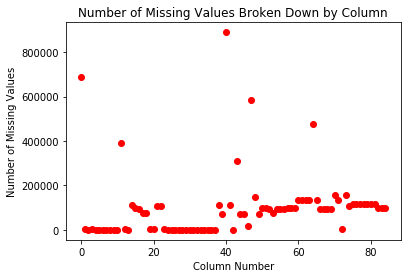

In [7]:
plt.figure(1)
plt.plot(df_nulls['col_num'],df_nulls['num_nulls'],'ro')
plt.title('Number of Missing Values Broken Down by Column')
plt.xlabel('Column Number')
plt.ylabel('Number of Missing Values')
#plt.yscale('log')
#plt.ylim(220000, 900000)

### Use a histogram plot now to see how columns with similar numbers of missing values are grouped together:

Text(0.5,0,'Number of Missing Values')

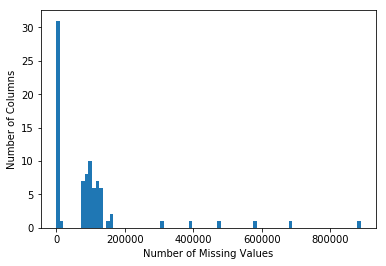

In [8]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(2)
plt.hist(df_nulls['num_nulls'], bins = 85)
plt.ylabel('Number of Columns')
plt.xlabel('Number of Missing Values')

### From visually inspecting the graph immediately above, it appears that a good cut-off value to use for dropping columns with missing values would be those with 'Number of Missing Values' less than 200,000.

In [9]:
df_nulls = df_nulls[df_nulls['num_nulls'] > 200000]
df_nulls

,col_num,num_nulls
0,0,685843
11,11,392318
40,40,889061
43,43,310267
47,47,584612
64,64,476524


### From the data that remains in the df_nulls dataframe, we can see which columns to drop, based on the condition stated above that the number of missing values should be greater than 200,000.

In [10]:
#df_nulls_copy.drop(labels = [0, 11, 40, 43, 47, 64], axis = 1)
list_missing = []
for x in [0, 11, 40, 43, 47, 64]:
    t = azdias.columns[x]
    list_missing.append(t)
print(list_missing)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


### From the above list of six columns we can see those which need to be dropped by label. Next, one only needs to use these labels to drop these columns from the azdias dataframe.

In [11]:
azdias = azdias.drop(['AGER_TYP',
                      'GEBURTSJAHR',
                      'TITEL_KZ',
                      'ALTER_HH',
                      'KK_KUNDENTYP',
                      'KBA05_BAUMAX'],
                     axis = 1)
azdias.head() # To verify that the six desired columns were dropped.

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column
From Figures 1 and 2 above, one can see that the majority of columns have fewer than 200,000 missing values. This trend was the motivation for choosing a cut-off value of 200,000 for the most number of missing values that a column can have and remain in our dataset as we proceed with the project. The six columns with missing values greater than 200,000 were determined to be: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX'. These six columns were removed from the azdias dataframe.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?
num_missing_by_row = azdias.isnull().sum(axis = 1)

In [13]:
num_missing_by_row

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

Text(0.5,0,'Number of Missing Values')

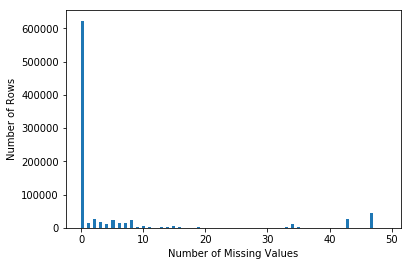

In [14]:
plt.figure(3)
plt.hist(num_missing_by_row, bins = 100)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')

### From the histogram plot immediately above, it appears that a threshold value of 25 is suitable for the number of missing values in each row of our dataframe.

In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
df_missing_few = azdias[azdias.isnull().sum(axis = 1) <= 25]
df_missing_many = azdias[azdias.isnull().sum(axis = 1) > 25]

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# List of the number of missing values by column in a pandas series:
azdias.isnull().sum()

ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
                          ...  
MIN_GEBA

### Now, let's create an ordered list by the number of missing values and take the first five elements for our comparison:

In [17]:
few_missing_values = azdias.isnull().sum()[azdias.isnull().sum() == 0].index.tolist()
comparison_list = few_missing_values[:5]
comparison_list

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER']

### The five columns to be used in our comparison are given by the list immediately preceeding above

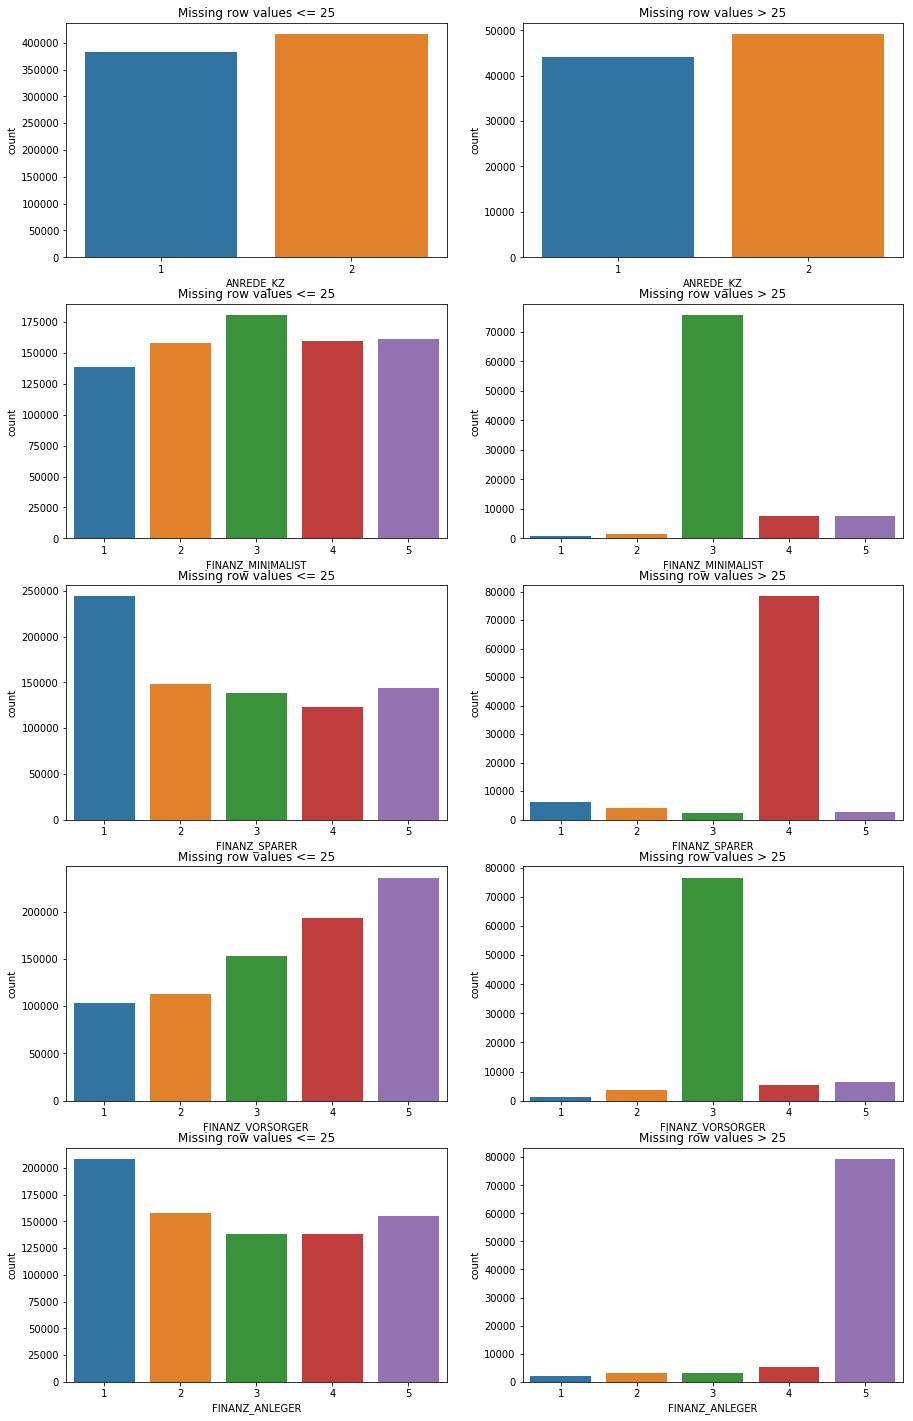

In [18]:
figure, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (15, 25))
for i in range(0,5):
    sns.countplot(df_missing_few[comparison_list[i]], ax = axs[i][0])
    axs[i][0].set_title('Missing row values <= 25')
    sns.countplot(df_missing_many[comparison_list[i]], ax = axs[i][1])
    axs[i][1].set_title('Missing row values > 25')

#### Discussion 1.1.3: Assess Missing Data in Each Row

In this analysis, we have looked at the number of missing values by row for the azdias dataset. From the histogram plot above, it was determined that a good threshold value to use for dividing the dataset into "Many missing" and "Few missing" subsets was 25 values. By dividing the data this way, and comparing the results qualitatively, we do see that there are considerable differences in the observed trends for the five columns that were studied in detail immediately above.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?

# Here we need to be careful to take into account the pre-processing information that we have already learned from
# the analysis so far, using the dataframe that has rows removed with missing values greater than our specified
# threshold of 25 values.
feat_info_cleaned = feat_info[feat_info.attribute.isin(df_missing_few.columns)]

In [20]:
feat_info_cleaned.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

### So from the output just above, we can see how many features there are of each data type, after removing rows with more than 25 missing values.

In [21]:
# Create a dataframe of only the categorical data
cat_var = feat_info_cleaned[feat_info_cleaned.type == 'categorical']
cat_var.head()

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# First let's separate the categorical data into binary and multi-level subsets:
bin_cat = [] # List of columns that are categorical with binary
ml_cat = [] # List of columns that are categorical with multi-level
for column in cat_var.attribute:
    if len(df_missing_few[column].unique()) == 2:
        bin_cat.append(column)
    elif len(df_missing_few[column].unique()) > 2:
        ml_cat.append(column)

In [23]:
print(bin_cat)
print(ml_cat)
print(len(bin_cat))
print(len(ml_cat))

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
4
14


In [24]:
df_missing_few[bin_cat].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,OST_WEST_KZ
1,2,0,1.0,W
2,2,1,0.0,W
3,2,0,0.0,W
4,1,0,0.0,W
5,2,0,0.0,W


### From the above subset of the df_missing_few dataframe, we can identify 'OST_WEST_KZ' as the column which currently has non-numerical data. Moving forward, we will need to re-encode these values numerically.

In [25]:
df_missing_few['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [26]:
df_clean = pd.get_dummies(data = df_missing_few, columns = ['OST_WEST_KZ'])
df_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1
2,3.0,2,3.0,1,4,1,2,3,5,1,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1
5,1.0,2,2.0,3,1,5,2,2,5,2,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1


### Now one can see that the 'OST_WEST_KZ' column has been re-encoded using numerical data by way of one hot encoding.

### Next, let's remove the multi-level categorical data from the dataframe.

In [27]:
for column in ml_cat:
    df_clean = df_clean.drop(column, axis = 1)

In [28]:
df_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1


#### Discussion 1.2.1: Re-Encode Categorical Features

For this part of the data pre-processing, we worked with categorical data. We started with the dataframe resulting from dropping rows having more than 25 missing values. From here, we determined that there were 18 columns of categorical data, which can be identified as 1) binary (either numeric or non-numeric) and 2) multi-level. For the binary numeric data, we left it as-is with no modifications. The binary non-numeric data column, 'OST_WEST_KZ', was re-encoded using get_dummies() to two new separate columns, having only values of either 0 or 1. The multi-level data was dropped from the latest dataframe.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Creating two new columns from the original, with data to be replaced later
df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']
df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE']
# Observe the dataframe column and its properties
print(df_clean['PRAEGENDE_JUGENDJAHRE'].head())
print(df_clean['PRAEGENDE_JUGENDJAHRE'].describe())
print(df_clean['PRAEGENDE_JUGENDJAHRE'].unique())

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64
count    769252.000000
mean          9.279986
std           4.026141
min           1.000000
25%           6.000000
50%           9.000000
75%          14.000000
max          15.000000
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64
[ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]


### Here is data from the Data_Dictionary.md file on the 'PRAEGENDE_JUGENDJAHRE' column:

- 1: 40s - war years (Mainstream, E+W)
- 2: 40s - reconstruction years (Avantgarde, E+W)
- 3: 50s - economic miracle (Mainstream, E+W)
- 4: 50s - milk bar / Individualisation (Avantgarde, E+W)
- 5: 60s - economic miracle (Mainstream, E+W)
- 6: 60s - generation 68 / student protestors (Avantgarde, W)
- 7: 60s - opponents to the building of the Wall (Avantgarde, E)
- 8: 70s - family orientation (Mainstream, E+W)
- 9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

### Now, let's use the information above to create two dictionaries, which we can use to replace the values in our two new variables:

In [30]:
# Notation for decade: 1 - 40s, 2 - 50s, 3 - 60s, etc
dict_decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

#Notation for movement: 0 - Mainstream, 1 - Avantgarde
dict_movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}

df_clean['DECADE'].replace(dict_decade, inplace = True)
df_clean['MOVEMENT'].replace(dict_movement, inplace = True)

In [31]:
df_clean['DECADE'].head()

1    6.0
2    6.0
3    4.0
4    4.0
5    2.0
Name: DECADE, dtype: float64

In [32]:
df_clean['MOVEMENT'].head()

1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
Name: MOVEMENT, dtype: float64

In [33]:
print(df_clean['DECADE'].unique())
print(df_clean['MOVEMENT'].unique())

[  6.   4.   2.   5.   3.  nan   1.]
[  0.   1.  nan]


### From the Data_Dictionary.md file, we have the following information:

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [34]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

df_clean['CAMEO_INTL_2015'].head(10)

1     51
2     24
3     12
4     43
5     54
6     22
7     14
8     13
9     15
10    51
Name: CAMEO_INTL_2015, dtype: object

In [35]:
df_clean['CAMEO_INTL_2015'].describe()

count     791840
unique        21
top           51
freq      133693
Name: CAMEO_INTL_2015, dtype: object

In [36]:
df_clean['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [37]:
# Creating two new variables
df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015']
df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']

In [38]:
# Make dictionaries for 'WEALTH' and 'LIFE_STAGE'
dict_wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

dict_life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
               '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
               '51':1, '52':2, '53':3, '54':4, '55':5}

In [39]:
# Use dictionaries above to replace data values in the two newly created columns
df_clean['WEALTH'].replace(dict_wealth, inplace = True)
df_clean['LIFE_STAGE'].replace(dict_life_stage, inplace = True)

In [40]:
df_clean['WEALTH'].head()

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: WEALTH, dtype: float64

In [41]:
df_clean['LIFE_STAGE'].head()

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: LIFE_STAGE, dtype: float64

#### Discussion 1.2.2: Engineer Mixed-Type Features

In this step of the data pre-processing, we started with the 'PRAEGENDE_JUGENDJAHRE' column. First, we created two new column variables called 'DECADE' and 'MOVEMENT' from the original column to hold information encoded in the original column. Next, we replaced the values in the new columns by creating a dictionary for each, taking into account how the original information was encoded in a single column from consulting the Data_Dictionary.md file. A similar procedure was done for the 'CAMEO_INTL_2015' column, where the new columns created were 'WEALTH and LIFE_STAGE'. Dictionaries for each were created for replacing the oringal values with new ones, determined from the Data_Dictionary.md file, as before. The original columns, namely 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' will be dropped before the final analysis, as they are no longer needed.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [42]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Let's take care of deleting the 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' columns, since they are no longer needed.

df_clean.drop(columns = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis = 1)

df_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,4.0,3.0,5.0,4.0,0,1,6.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,0,1,6.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,4.0,2.0,3.0,3.0,0,1,4.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,3.0,4.0,6.0,5.0,0,1,4.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,5.0,2.0,3.0,3.0,0,1,2.0,0.0,5.0,4.0


In [43]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Finally, let's remove all features that are of data type "mixed".
list_mixed = feat_info_cleaned[feat_info_cleaned.type == 'mixed']

for item in list_mixed['attribute']:
    if item in df_clean.columns:
        df_clean.drop(item, axis = 1, inplace = True)
        
df_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,4.0,3.0,5.0,4.0,0,1,6.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,0,1,6.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,4.0,2.0,3.0,3.0,0,1,4.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,3.0,4.0,6.0,5.0,0,1,4.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,5.0,2.0,3.0,3.0,0,1,2.0,0.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [44]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Loading feature summary file
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',';')
    
    # Replace missing values with NANs
    for i in range(len(feat_info)):
        vals = feat_info.iloc[i]['missing_or_unknown']
        vals = vals.strip("[")
        vals = vals.strip("]")
        vals = vals.split(sep = ",")
        vals = [int(z) if (z != 'X' and z != 'XX' and z != '') else z for z in vals]
        if vals != ['']:
            df = df.replace({feat_info.iloc[i]['attribute']: vals}, np.nan)
    
    # Removing columns with missing values greater than the previously determined threshold value
    columns_to_remove = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH',
                      'KK_KUNDENTYP', 'KBA05_BAUMAX', 'CAMEO_DEU_2015']
    for column in columns_to_remove:
        df.drop(column, axis =1, inplace = True)
        
    # Remove rows with more than 25 missing values
    df_cleaned = df[df.isnull().sum(axis = 1) <= 25]
    
    # Re-encoding non-numeric binary feature to numeric one
    df_cleaned = pd.get_dummies(data = df_cleaned, columns = ['OST_WEST_KZ'])
    
    # Drop multi-level features
    feat_info_cleaned = feat_info[feat_info.attribute.isin(df_cleaned.columns)]
    cat_var = feat_info_cleaned[feat_info_cleaned.type == 'categorical'] # a dataframe of only categegorical features
    ml_cat = [] # List of columns that are categorical and multi-level
    for column in cat_var.attribute:
        if len(df_cleaned[column].unique()) > 2:
            ml_cat.append(column)
    
    # Drop all multi-level categorical data from our dataframe
    for ele in ml_cat:
        df_cleaned = df_cleaned.drop(ele, axis = 1)
    
    # Mixed features for 'PRAEGENDE_JUGENDJAHRE' column
    df_cleaned['DECADE'] = df_cleaned['PRAEGENDE_JUGENDJAHRE']
    df_cleaned['MOVEMENT'] = df_cleaned['PRAEGENDE_JUGENDJAHRE']
    # Dictionaries for replacing values in 'PRAEGENDE_JUGENDJAHRE' column
    dict_decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    dict_movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    # Replace values with dicts above
    df_cleaned['DECADE'].replace(dict_decade, inplace = True)
    df_cleaned['MOVEMENT'].replace(dict_movement, inplace = True)
    
    # Mixed features for 'CAMEO_INTL_2015' column
    df_cleaned['WEALTH'] = df_cleaned['CAMEO_INTL_2015']
    df_cleaned['LIFE_STAGE'] = df_cleaned['CAMEO_INTL_2015']
    # Make dictionaries for replacing values in 'CAMEO_INTL_2015' column
    dict_wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}
    dict_life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
               '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
               '51':1, '52':2, '53':3, '54':4, '55':5}
    # Replace values with dicts above
    df_cleaned['WEALTH'].replace(dict_wealth, inplace = True)
    df_cleaned['LIFE_STAGE'].replace(dict_life_stage, inplace = True)
    
    # Remove columns that are no longer needed
    df_cleaned.drop(columns = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis = 1)
    
    # Remove all remaining features that are of type "mixed"
    list_mixed = feat_info_cleaned[feat_info_cleaned.type == 'mixed']
    for item in list_mixed['attribute']:
        if item in df_cleaned.columns:
            df_cleaned.drop(item, axis = 1, inplace = True)
    
    # Return the cleaned dataframe
    return df_cleaned

In [45]:
# Test that the clean_data() function works without errors
azdias_copy = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
df_function_test = clean_data(azdias_copy)

In [46]:
df_function_test.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,4.0,3.0,5.0,4.0,0,1,6.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,0,1,6.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,4.0,2.0,3.0,3.0,0,1,4.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,3.0,4.0,6.0,5.0,0,1,4.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,5.0,2.0,3.0,3.0,0,1,2.0,0.0,5.0,4.0


### From the output just above, it seems that our clean_data() function works as desired.

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [47]:
# Here, I choose to replace the NAN values with the median value for each column, since the median value in statistics
# is less susceptible to outliers than the mean.
impute_median = Imputer(strategy = 'median')
df_clean_imputed = pd.DataFrame(impute_median.fit_transform(df_clean))

In [48]:
df_clean_imputed.columns = df_clean.columns
df_clean_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,4.0,3.0,5.0,4.0,0.0,1.0,6.0,0.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,4.0,3.0,5.0,2.0,0.0,1.0,6.0,1.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,4.0,2.0,3.0,3.0,0.0,1.0,4.0,0.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,3.0,4.0,6.0,5.0,0.0,1.0,4.0,0.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,5.0,2.0,3.0,3.0,0.0,1.0,2.0,0.0,5.0,4.0


In [49]:
# Apply feature scaling to the general population demographics data.
feat_scale = StandardScaler()
df_clean_imputed_scaled = pd.DataFrame(feat_scale.fit_transform(df_clean_imputed))
df_clean_imputed_scaled.columns = df_clean_imputed.columns
df_clean_imputed_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766616,0.957933,-1.494605,1.537983,-1.040689,1.466048,0.958818,1.339234,-0.530442,1.096551,...,0.574231,-0.166432,-0.127075,0.684853,-0.517442,0.517442,1.172911,-0.530442,1.186211,-1.266976
1,0.200529,0.957933,-1.494605,0.864617,-1.766963,-0.570958,0.244259,1.339234,1.885219,1.096551,...,0.574231,-0.166432,-0.127075,-0.789058,-0.517442,0.517442,1.172911,1.885219,-0.868182,0.761271
2,1.184102,0.957933,0.683156,-0.482116,1.138133,-0.570958,-1.184858,-0.791347,-0.530442,-0.257026,...,0.574231,-1.169962,-0.997594,-0.052103,-0.517442,0.517442,-0.223444,-0.530442,-1.552980,-0.590894
3,0.200529,-1.043914,0.683156,0.191250,0.411859,-1.249960,0.244259,-0.791347,-0.530442,1.096551,...,-0.337218,0.837098,0.308185,1.421808,-0.517442,0.517442,-0.223444,-0.530442,0.501413,0.085189
4,-1.766616,0.957933,-0.042764,-1.155482,1.138133,-0.570958,-0.470299,1.339234,-0.530442,1.096551,...,1.485680,-1.169962,-0.997594,-0.052103,-0.517442,0.517442,-1.619800,-0.530442,1.186211,0.761271


### Discussion 2.1: Apply Feature Scaling

In this section, I began by choosing to replace all NAN values with the median value of that columns, using the Imputer() function from sklearn. Next, I performed feature scaling using the StandardScaler() function.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [50]:
# Apply PCA to the data.
dim_red = PCA()
dim_red.fit(df_clean_imputed_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0.5,0,'Principal Component')

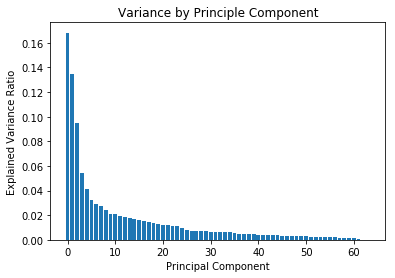

In [51]:
# Investigate the variance accounted for by each principal component.
# Here we can use the explained_variance_ratio_ attribute
plt.bar(range(len(dim_red.explained_variance_ratio_)), dim_red.explained_variance_ratio_)
plt.title('Variance by Principle Component')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')

Text(0.5,0,'Number of Components')

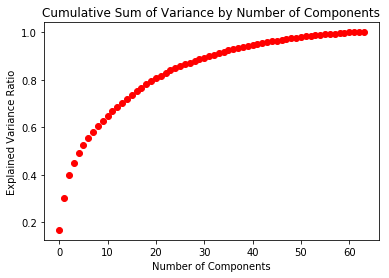

In [52]:
# Here it is also useful to look at the cumulative sum
plt.plot(range(len(dim_red.explained_variance_ratio_)), np.cumsum(dim_red.explained_variance_ratio_), 'ro')
plt.title('Cumulative Sum of Variance by Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Components')

In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.
dim_red_40 = PCA(n_components = 40)
df_dim_red_40 = dim_red_40.fit_transform(df_clean_imputed_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

In summary, for the analysis in this section I reduced the number of componenets from 64 to 40. This represents a 37.5% reduction in the number of components, while still retaining an explained variance ratio of over 90%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def weights_pca(dim_red, i):
    df = pd.DataFrame(dim_red.components_, columns = list(df_clean_imputed_scaled.columns))
    weights = df.iloc[i].sort_values(ascending = False)
    return weights

In [55]:
# Using the weights_pca() function to calculate weights of the first (i=0) principal component
weights_pca_0 = weights_pca(dim_red_40, i = 0)
print(weights_pca_0)

PLZ8_ANTG3               0.227050
PLZ8_ANTG4               0.220588
WEALTH                   0.207599
HH_EINKOMMEN_SCORE       0.203936
ORTSGR_KLS9              0.197552
EWDICHTE                 0.195087
FINANZ_HAUSBAUER         0.164003
KBA05_ANTG4              0.156252
PLZ8_ANTG2               0.153329
ARBEIT                   0.146234
FINANZ_SPARER            0.142309
KBA05_ANTG3              0.138529
ANZ_HAUSHALTE_AKTIV      0.137264
RELAT_AB                 0.135561
SEMIO_PFLICHT            0.111111
SEMIO_REL                0.108595
DECADE                   0.095865
SEMIO_RAT                0.091508
SEMIO_TRADV              0.085176
SEMIO_MAT                0.076630
SEMIO_FAM                0.075123
SEMIO_KULT               0.069351
FINANZ_UNAUFFAELLIGER    0.068803
REGIOTYP                 0.068197
FINANZ_ANLEGER           0.067074
OST_WEST_KZ_O            0.060660
SEMIO_SOZ                0.041834
PLZ8_HHZ                 0.040501
SEMIO_KAEM               0.040495
KKK           

In [56]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_pca_1 = weights_pca(dim_red_40, i = 1)
print(weights_pca_1)

ALTERSKATEGORIE_GROB     0.261855
FINANZ_VORSORGER         0.233580
SEMIO_ERL                0.231726
SEMIO_LUST               0.184705
RETOURTYP_BK_S           0.163719
W_KEIT_KIND_HH           0.119228
FINANZ_HAUSBAUER         0.116052
SEMIO_KRIT               0.114787
SEMIO_KAEM               0.111574
ANREDE_KZ                0.090429
PLZ8_ANTG3               0.087455
EWDICHTE                 0.086922
ORTSGR_KLS9              0.085888
PLZ8_ANTG4               0.083660
WEALTH                   0.071061
SEMIO_DOM                0.070177
FINANZ_MINIMALIST        0.069121
KBA05_ANTG4              0.069111
ARBEIT                   0.066064
RELAT_AB                 0.061988
WOHNDAUER_2008           0.061500
ANZ_HAUSHALTE_AKTIV      0.060831
PLZ8_ANTG2               0.059620
HH_EINKOMMEN_SCORE       0.053552
KBA05_ANTG3              0.044611
ANZ_HH_TITEL             0.030450
OST_WEST_KZ_O            0.028760
REGIOTYP                 0.016296
PLZ8_HHZ                 0.010422
ANZ_TITEL     

In [57]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_pca_2 = weights_pca(dim_red_40, i = 2)
print(weights_pca_2)

SEMIO_VERT               0.345327
SEMIO_SOZ                0.262154
SEMIO_FAM                0.249675
SEMIO_KULT               0.235056
FINANZ_MINIMALIST        0.156399
RETOURTYP_BK_S           0.108411
FINANZ_VORSORGER         0.100574
W_KEIT_KIND_HH           0.091008
ALTERSKATEGORIE_GROB     0.079375
SEMIO_REL                0.069142
SEMIO_LUST               0.064712
SEMIO_MAT                0.055794
GREEN_AVANTGARDE         0.046911
MOVEMENT                 0.046911
ORTSGR_KLS9              0.045558
PLZ8_ANTG4               0.044730
EWDICHTE                 0.044471
PLZ8_ANTG3               0.044137
ARBEIT                   0.035864
WOHNDAUER_2008           0.033048
RELAT_AB                 0.031114
PLZ8_ANTG2               0.028608
KBA05_ANTG4              0.028127
WEALTH                   0.027354
ANZ_HAUSHALTE_AKTIV      0.025066
OST_WEST_KZ_O            0.019294
ANZ_HH_TITEL             0.013188
KBA05_ANTG3              0.009766
ANZ_TITEL                0.009652
PLZ8_HHZ      

### Discussion 2.3: Interpret Principal Components

### Here is a summary of the extreme values for the first principal component

i = 0 case:
- PLZ8_ANTG3               0.227050
- PLZ8_ANTG4               0.220588
- ...

- PLZ8_ANTG1              -0.227754
- MOBI_REGIO              -0.243064


For this, we can look at PLZ8_ANTG3 and PLZ8_ANTG4, which are the the number 6-10 and 10+ homes in the PLZ8 region, respectively. These number both show large postive values, meaning that they should increase/decrease together. This makes sense, considering that both represent how large households respond to changing conditions.

In contrast, we can compare PLZ8_ANTG3 and PLZ8_ANTG1, which show large values having opposite signs, meaning that as one increases/decreases, the other should respond in the opposite way. This makes sense because PLZ8_ANTG3 represents large households, while MOBI_REGIO represents liklihood of movement, and large families are less likely to move than small ones due to various ties to the area.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [58]:
def score_kmeans(input_data, n_clusters):
    kmeans = KMeans(n_clusters = n_clusters)
    model = kmeans.fit(input_data)
    kmeans_score = np.abs(model.score(input_data))
    return kmeans_score

In [59]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

list_scores = []
clusters = [j for j in range(1,21)]
for c in clusters:
    list_scores.append(score_kmeans(df_dim_red_40, c))

### Saving results from first finished calc above fore re-plotting, so no need to repeat long calculation when the workspace resets
- clusters: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
- list_scores: [48112371.359190062, 41671096.498753287, 38396911.957530014, 36305345.150424764, 34823411.652104348, 33573496.675650395, 32433698.391375318, 31570050.425414264, 30974124.344275046, 30517549.278146259, 29804601.422318652, 29225479.041239042, 29029585.494666364, 28578096.975754373, 28287430.297849629]

Text(0,0.5,'Average within cluster distance')

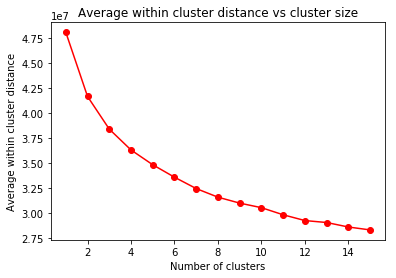

In [60]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

clusters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
list_scores = [48112371.359190062, 41671096.498753287, 38396911.957530014, 36305345.150424764, 34823411.652104348,
               33573496.675650395, 32433698.391375318, 31570050.425414264, 30974124.344275046, 30517549.278146259,
               29804601.422318652, 29225479.041239042, 29029585.494666364, 28578096.975754373, 28287430.297849629]

plt.plot(clusters, list_scores, 'ro-')
plt.title('Average within cluster distance vs cluster size')
plt.xlabel('Number of clusters')
plt.ylabel('Average within cluster distance')

### Now, using the value of 14 clusters, let's re-fit a KMeans() instance.

In [61]:
kmeans = KMeans(n_clusters = 14)
model_clusters_14 = kmeans.fit(df_dim_red_40)
df_dim_red_40_predict = model_clusters_14.predict(df_dim_red_40)

### Discussion 3.1: Apply Clustering to General Population

After performing the calculation to determine the average within-cluster distance for integer cluster sizes ranging from 1 to 15, I determined that there seems to be a feature near a cluster size of 14. Therefore, moving forward, I will choose 14 clusters as the final number to use moving forward with this analysis.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [62]:
# Load in the customer demographics data.
data_customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [63]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df_customers_cleaned = clean_data(data_customers)

In [64]:
# Impute data
df_customers_cleaned_imputed = pd.DataFrame(impute_median.fit_transform(df_customers_cleaned))
df_customers_cleaned_imputed.columns = df_customers_cleaned.columns
df_customers_cleaned_imputed.index = df_customers_cleaned.index
df_customers_cleaned_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,5.0,1.0,2.0,1.0,0.0,1.0,2.0,1.0,1.0,3.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,2.0,3.0,5.0,3.0,0.0,1.0,2.0,1.0,3.0,4.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,4.0,1.0,3.0,1.0,0.0,1.0,1.0,0.0,2.0,4.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,3.0,3.0,5.0,1.0,0.0,1.0,4.0,0.0,4.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,5.0,3.0,7.0,5.0,0.0,1.0,2.0,1.0,3.0,4.0


In [65]:
# Apply standard scaling
df_customers_cleaned_imputed_scaled = pd.DataFrame(feat_scale.transform(df_customers_cleaned_imputed))
df_customers_cleaned_imputed_scaled.columns = df_customers_cleaned_imputed.columns
df_customers_cleaned_imputed_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.184102,-1.043914,1.409077,-1.155482,1.138133,-1.249960,-0.470299,-0.791347,1.885219,-1.610602,...,1.485680,-2.173492,-1.432853,-1.526014,-0.517442,0.517442,-1.619800,1.885219,-1.552980,0.085189
1,1.184102,0.957933,1.409077,-1.155482,1.138133,-1.249960,0.958818,0.629041,1.885219,-0.257026,...,-1.248668,-0.166432,-0.127075,-0.052103,-0.517442,0.517442,-1.619800,1.885219,-0.183385,0.761271
2,1.184102,-1.043914,1.409077,-1.155482,1.138133,-0.570958,-1.184858,-0.791347,-0.530442,-0.257026,...,0.574231,-2.173492,-0.997594,-1.526014,-0.517442,0.517442,-2.317978,-0.530442,-0.868182,0.761271
3,0.200529,-1.043914,-0.042764,-1.155482,0.411859,0.787046,1.673376,-0.791347,-0.530442,1.096551,...,-0.337218,-0.166432,-0.127075,-1.526014,-0.517442,0.517442,-0.223444,-0.530442,0.501413,-1.266976
4,0.200529,-1.043914,1.409077,-1.155482,1.138133,-1.249960,-0.470299,-0.081153,1.885219,1.096551,...,1.485680,-0.166432,0.743444,1.421808,-0.517442,0.517442,-1.619800,1.885219,-0.183385,0.761271


In [66]:
# Apply PCA transform
array_customers_cleaned_imputed_scaled_pca = dim_red_40.transform(df_customers_cleaned_imputed_scaled)
predicition_customers = model_clusters_14.predict(array_customers_cleaned_imputed_scaled_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'Customer Dataset')

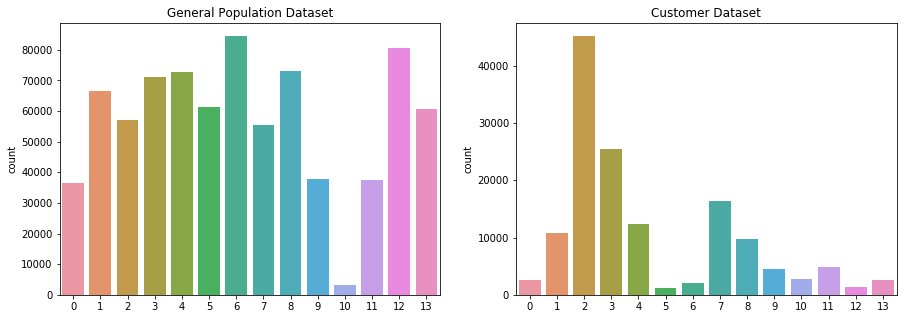

In [67]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
sns.countplot(df_dim_red_40_predict, ax = axs[0])
sns.countplot(predicition_customers, ax = axs[1])
axs[0].set_title('General Population Dataset')
axs[1].set_title('Customer Dataset')


In [68]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_12 = feat_scale.inverse_transform(dim_red_40.inverse_transform(model_clusters_14.cluster_centers_[12]))

In [69]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_6 = feat_scale.inverse_transform(dim_red_40.inverse_transform(model_clusters_14.cluster_centers_[6]))

In [71]:
customer_overrepresented = pd.Series(data = centroid_12, index = df_customers_cleaned.columns)
customer_overrepresented.sort_values()

ANZ_TITEL                   0.000021
SOHO_KZ                     0.007987
MOVEMENT                    0.034566
GREEN_AVANTGARDE            0.034566
ANZ_HH_TITEL                0.048328
OST_WEST_KZ_O               0.264866
KBA05_ANTG1                 0.429437
KBA05_ANTG4                 0.582044
OST_WEST_KZ_W               0.735134
FINANZ_MINIMALIST           1.188721
KBA05_ANTG3                 1.200386
PLZ8_ANTG4                  1.272848
KBA05_ANTG2                 1.315466
ANZ_PERSONEN                1.475753
PLZ8_ANTG1                  1.492165
ALTERSKATEGORIE_GROB        1.678633
MOBI_REGIO                  1.784219
ANREDE_KZ                   1.993016
LIFE_STAGE                  2.046282
KONSUMNAEHE                 2.104510
KBA05_GBZ                   2.143416
HEALTH_TYP                  2.160122
FINANZ_VORSORGER            2.203848
SEMIO_VERT                  2.318803
PLZ8_ANTG3                  2.424666
RETOURTYP_BK_S              2.658208
PLZ8_GBZ                    2.709216
O

In [72]:
customer_underrepresented = pd.Series(data = centroid_6, index = df_customers_cleaned.columns)
customer_underrepresented

ALTERSKATEGORIE_GROB        1.754064
ANREDE_KZ                   1.964768
FINANZ_MINIMALIST           2.252213
FINANZ_SPARER               3.968828
FINANZ_VORSORGER            2.260811
FINANZ_ANLEGER              4.338849
FINANZ_UNAUFFAELLIGER       4.029524
FINANZ_HAUSBAUER            2.924745
GREEN_AVANTGARDE            0.188950
HEALTH_TYP                  2.255056
RETOURTYP_BK_S              2.561834
SEMIO_SOZ                   2.628158
SEMIO_FAM                   3.748806
SEMIO_REL                   5.217617
SEMIO_MAT                   4.965318
SEMIO_VERT                  2.619749
SEMIO_LUST                  3.243886
SEMIO_ERL                   4.260124
SEMIO_KULT                  4.025360
SEMIO_RAT                   6.119006
SEMIO_KRIT                  5.540181
SEMIO_DOM                   5.926959
SEMIO_KAEM                  5.523935
SEMIO_PFLICHT               5.869726
SEMIO_TRADV                 5.790700
SOHO_KZ                     0.008599
ANZ_PERSONEN                1.945516
A

In [74]:
final_comparison = pd.DataFrame({"columns": df_customers_cleaned.columns,
                               "centroid_12": centroid_12,
                               "centroid_6": centroid_6})
final_comparison

,columns,centroid_12,centroid_6
0,ALTERSKATEGORIE_GROB,1.678633,1.754064
1,ANREDE_KZ,1.993016,1.964768
2,FINANZ_MINIMALIST,1.188721,2.252213
3,FINANZ_SPARER,4.269382,3.968828
4,FINANZ_VORSORGER,2.203848,2.260811
5,FINANZ_ANLEGER,4.134591,4.338849
6,FINANZ_UNAUFFAELLIGER,3.744243,4.029524
7,FINANZ_HAUSBAUER,4.199735,2.924745
8,GREEN_AVANTGARDE,0.034566,0.188950
9,HEALTH_TYP,2.160122,2.255056


### Discussion 3.3: Compare Customer Data to Demographics Data

For this final part of the analysis, using k-means clustering I compared the results from the cutomer data set to the one for the general population of Germany. For the optimal case of 14 clusters, I found that between these two data sets centroid 12 was overrepresented in the customer data set compared to the general population. Additionally, centroid 6 was underrepresented in the customer data set compared to the one for the general population. Generally, from looking at the results of this analysis, the mail order company should target households that are older and in good financial standing. The households that are likely not to be a good target for this company are younger people who are less financially secure. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.